In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import keras.backend as K
from keras.metrics import binary_crossentropy
from math import sqrt
from skimage.transform import resize
import logging
import sys
import tensorflow as tf
import sys; #sys.path.append('../')
from src.models.clr_callback import *
from src.models.unet_dilation import UNet
from src.utils.runtime import gpu_selection
from src.utils.data import random_transforms
from src.utils.model import dice_coef, jaccard_coef
import cv2
import numpy as np
import cv2
import glob
import random
from matplotlib.image import imsave
import mahotas as mh
from scipy import ndimage
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.model import dice_coef, jaccard_coef,tru_pos,fls_pos,tru_neg,fls_neg


sns.set_style("whitegrid", {'axes.grid' : False})


In [11]:
import keras

In [12]:
#model = UNet()
model = UNet('unet')
model.config['data_path'] = '.'
model.load_data()

In [13]:
gpu_selection(visible_devices="0")
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)

In [14]:
model.compile() # THIS IS USING BEST VALIDATION LOSS WEIGHTS :]
model.net.load_weights('/well/lindgren/craig/isbi-2012/checkpoints/unet_1024_dilation/weights_loss_val.weights')
model.net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1024, 1024)    0                                            
____________________________________________________________________________________________________
reshape_3 (Reshape)              (None, 1024, 1024, 1) 0           input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_47 (Conv2D)               (None, 1024, 1024, 44 440         reshape_3[0][0]                  
____________________________________________________________________________________________________
conv2d_48 (Conv2D)               (None, 1024, 1024, 44 17468       conv2d_47[0][0]                  
___________________________________________________________________________________________

In [15]:
def metric_wrapper(yt, yp, metric):
    return K.get_value(metric(K.variable(yt), K.variable(yp)))

In [16]:
val_imgs  = np.load('montage_img_val.npy')
val_masks = np.load('montage_msk_val.npy')

In [65]:
import time
start = time.time()
data_gen = model.batch_gen_trn(imgs=val_imgs, msks=val_masks, batch_size=4)
img_batch, msk_batch = next(data_gen)
prd_batch = model.net.predict(img_batch)
stop = time.time()
print(stop-start)

1.4659442901611328


/apps/well/python/3.4.6-gcc4.8.2/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


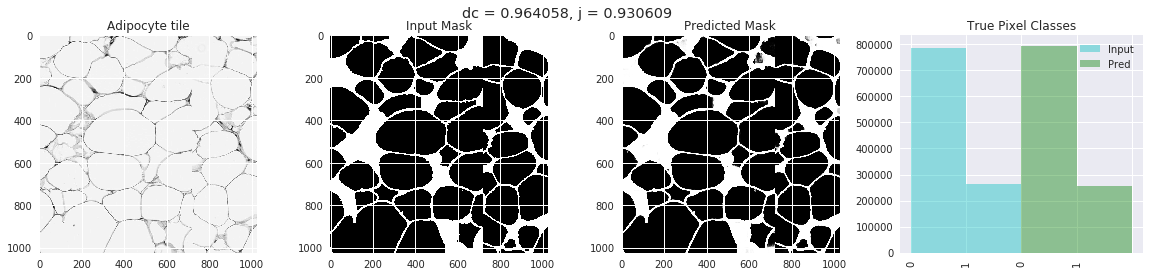

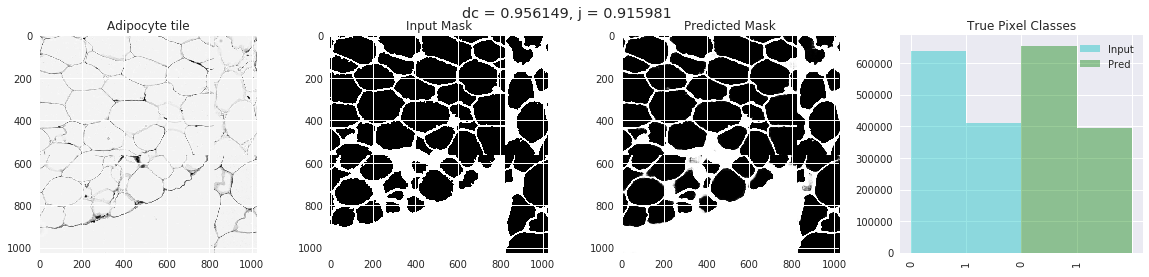

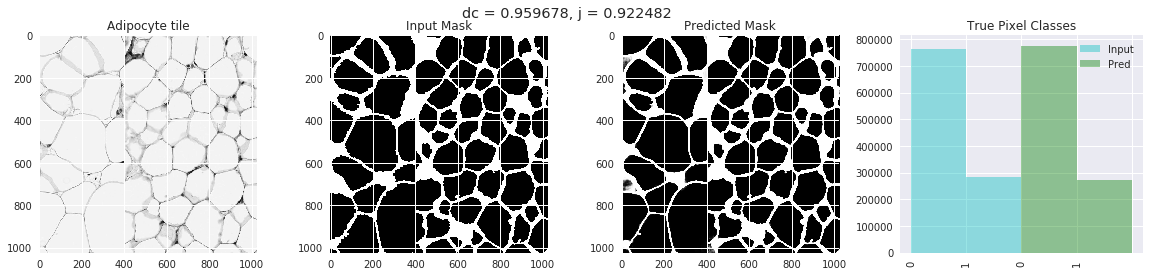

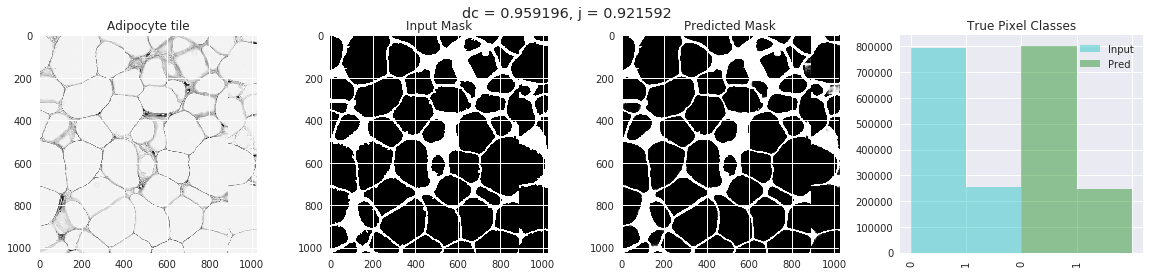

In [66]:
for img, msk, prd in zip(img_batch, msk_batch, prd_batch):
    r = c = int(sqrt(img.size))
    d = metric_wrapper(msk, prd, dice_coef)
    j = metric_wrapper(msk, prd, jaccard_coef)
    fig,_ = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
    fig.axes[0].set_title('Adipocyte tile')
    fig.axes[0].imshow(img.reshape(r,c), cmap='gray')
    fig.axes[1].set_title('Input Mask')
    fig.axes[1].imshow(msk.reshape(r,c), cmap='gray')
    fig.axes[2].set_title('Predicted Mask')
    fig.axes[2].imshow(prd.reshape(r,c), cmap='gray')
    fig.axes[3].set_title('True Pixel Classes')
    fig.axes[3].hist(msk.reshape(msk.size), label='Input', alpha=0.4, bins=2,color='c')
    fig.axes[3].hist(prd.reshape(prd.size) + 1, label='Pred', alpha=0.4, bins=2,color='g')
    fig.axes[3].set_xticklabels([0,0,1,0,1],rotation='vertical')
    fig.axes[3].legend()
    fig.suptitle('dc = %s, j = %s' % (d,j))    
    plt.show()

In [21]:
def precision(msk_batch,prd_batch):
    prec=[]
    recall=[]
    for i,_ in enumerate(msk_batch):
        TP = metric_wrapper(msk_batch[i], prd_batch[i], tru_pos)
        TN = metric_wrapper(msk_batch[i], prd_batch[i], tru_neg)
        FN = metric_wrapper(msk_batch[i], prd_batch[i], fls_neg)
        FP = metric_wrapper(msk_batch[i], prd_batch[i], fls_pos)
        prec.append(TP/(TP+FP))
        recall.append(TP/(TP+FN))
    return (prec,recall)

In [22]:
prec,recall = precision(msk_batch,prd_batch)

In [23]:
# Number of false positives and false negative pixels is so low ( and true positives so high), 
# precision/recall basically 1.
np.mean(prec),np.mean(recall)

(0.99938868780773871, 0.99892023832593924)

In [24]:
normalize = lambda x: (x - _mean) / (_std + 1e-10)


Out of sample prediction on an image neither trained nor validated on.

In [25]:

test_tiles = glob.glob('*.jpg')
test_samples=[]
for i in test_tiles:
    test_sample=cv2.imread(i,0)
    test_sample = np.array(test_sample,np.float32) /255
    #test_sample=cv2.resize(test_sample,(1024,1024))
    _mean, _std = np.mean(test_sample), np.std(test_sample)
    test_sample=normalize(test_sample)
    test_samples.append(test_sample)
test_samples=np.array(test_samples)

In [26]:
test_samples.shape

(4, 1024, 1024)

/apps/well/python/3.4.6-gcc4.8.2/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


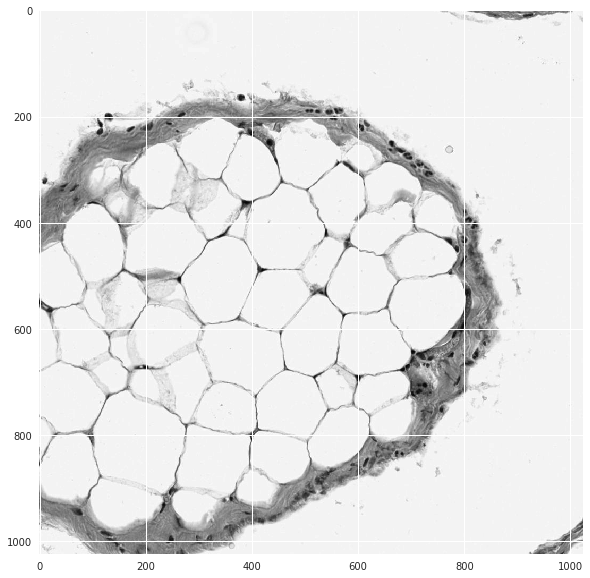

In [49]:
plt.figure(figsize=(10,10))
plt.imshow(test_samples[3],cmap='gray')
plt.show()

In [50]:
prd_batch = model.net.predict(test_samples,batch_size=4)

/apps/well/python/3.4.6-gcc4.8.2/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


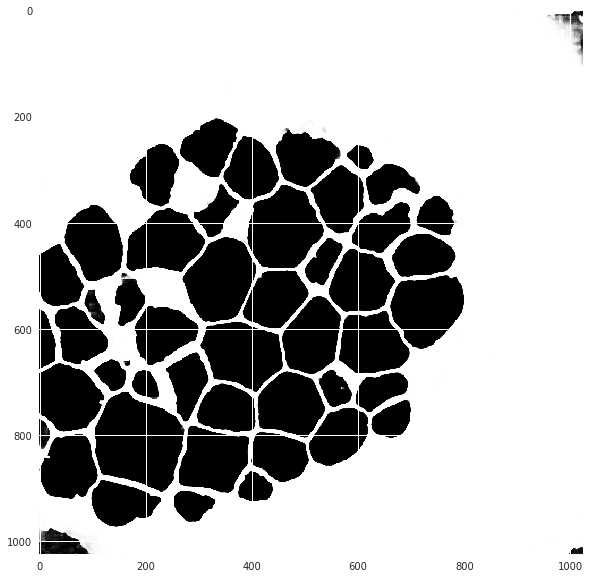

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(prd_batch[3],cmap='gray')
plt.show()

In [53]:
img = np.array(prd_batch[3] * 255,dtype='uint8')

In [54]:
T = mh.thresholding.otsu(img)
print('Otsu threshold is: ',str(T))

Otsu threshold is:  127


/apps/well/python/3.4.6-gcc4.8.2/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


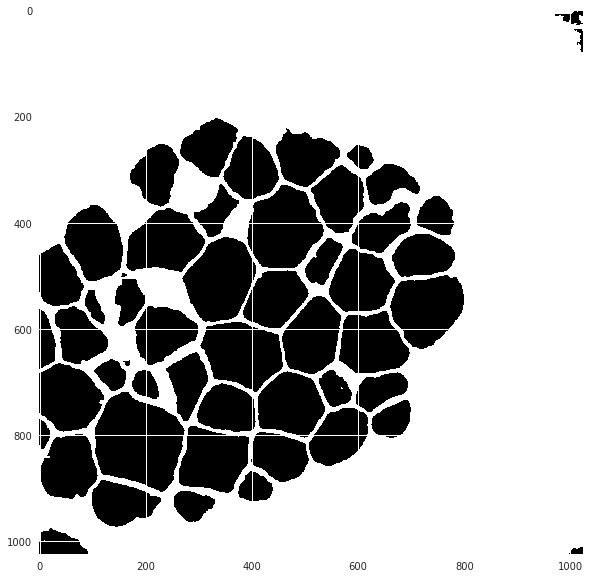

In [55]:
plt.figure(figsize=(10,10))
plt.imshow(img > T ,cmap='gray')
plt.show()

In [56]:
blobs = np.where(img>T,0, 1)
blobs = ndimage.morphology.binary_fill_holes(blobs,structure=np.ones((5,5))).astype(int)
labels, no_objects = ndimage.label(blobs)
props = regionprops(blobs)


/apps/well/python/3.4.6-gcc4.8.2/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


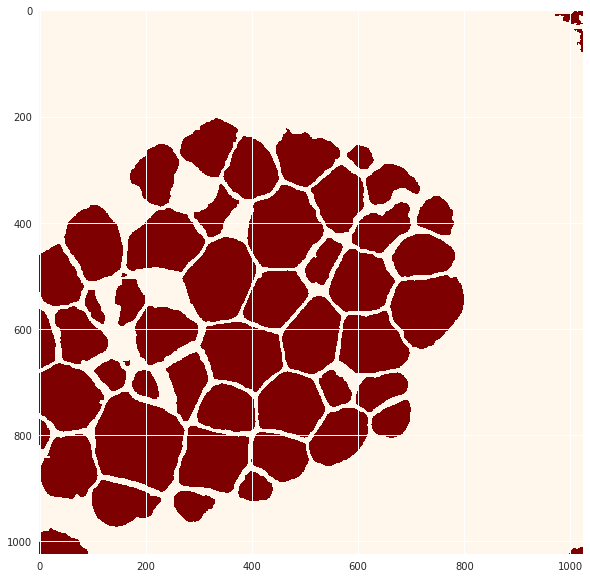

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(blobs)
plt.show()

In [58]:
imsave('mask.pred.tif',blobs)

In [59]:
labelled=ndimage.label(blobs)
resh_labelled=labelled[0].reshape((img.shape[0],img.shape[1])) #labelled is a tuple: only the first element matters


In [60]:
props=regionprops(resh_labelled) 


In [61]:
size={i:props[i].area for i in range (0, no_objects)}

In [62]:
no_of_cells=(sum(i > 200 and i < 50000 for i in size.values()))
areas=[i for i in size.values() if i >= 200 and i <= 70000]
print('Number of Cells counted: '+str(no_of_cells))

Number of Cells counted: 50


/apps/well/python/3.4.6-gcc4.8.2/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


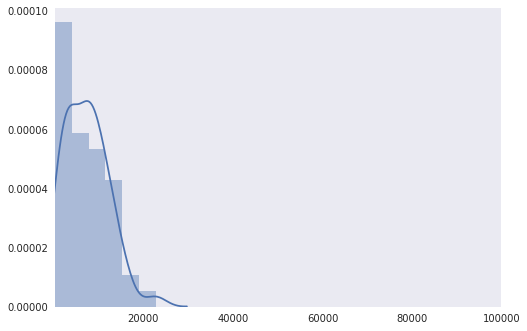

In [63]:
sns.set(); 
ax = sns.distplot(areas)
ax.set(xlim=(round(np.min(areas)), 100000))
ax.grid(False)
plt.show()


/apps/well/python/3.4.6-gcc4.8.2/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


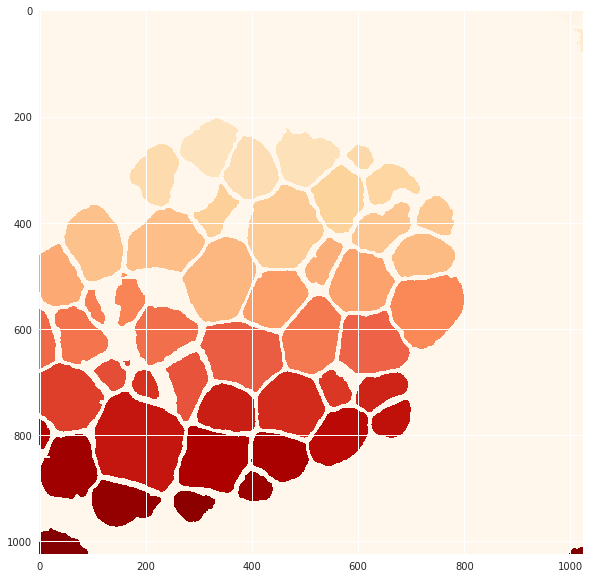

In [64]:
plt.figure(figsize=(10,10))
plt.set_cmap('OrRd')
plt.imshow(labels,origin='upper')
plt.show()

In [44]:
plt.imsave('predicted_mask.png',prd_batch[0],cmap='gray')